In [1]:
# ✅ 4. Import modules
import os
from ultralyticsplus import YOLO, render_result

In [2]:
# ✅ 3. Fix PyTorch 2.6+ UnpicklingError
import torch
from torch.serialization import add_safe_globals
from torch.nn import Sequential
add_safe_globals([Sequential])

In [3]:
# ✅ 1. Mount Google Drive
# ✅ 5. Set path to your image folder (5 images only)
images_dir = "Complete-Blood-Cell-Count-Dataset-master/Training/Images"
annotations_dir = "Complete-Blood-Cell-Count-Dataset-master/Training/Annotations"

all_images = [os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.jpg')]
selected_images = all_images[:5]  # use first 5 .jpg images

Sample Image Files: ['BloodImage_00315.jpg', 'BloodImage_00301.jpg', 'BloodImage_00117.jpg', 'BloodImage_00103.jpg', 'BloodImage_00063.jpg']


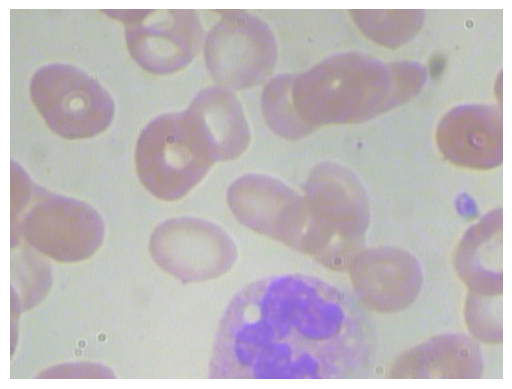

In [4]:

print("Sample Image Files:", os.listdir(images_dir)[:5])
#print("Sample Annotation Files:", os.listdir(annotations_dir)[:5])
import matplotlib.pyplot as plt
from PIL import Image

# Load an image
sample_image_path = os.path.join(images_dir, os.listdir(images_dir)[0])  # First image in the directory
img = Image.open(sample_image_path)

# Display image
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()

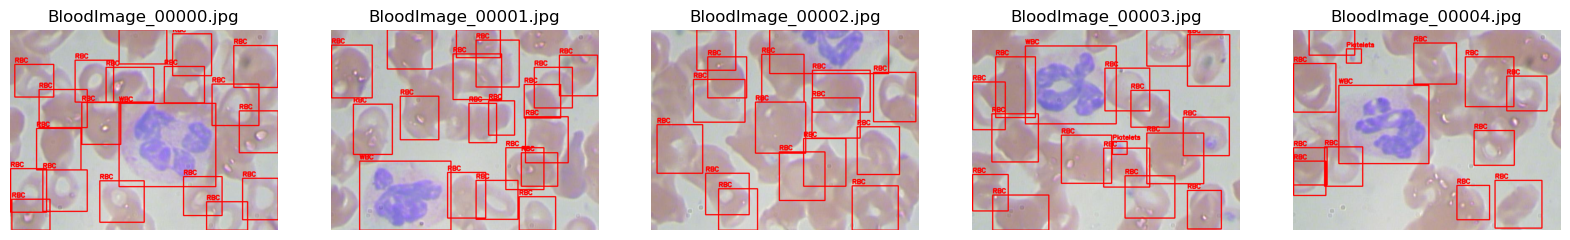

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image

# Get the first 5 images
image_files = sorted(os.listdir(images_dir))[:5]  # Sorting ensures consistency

# Plot all images in a single figure
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for idx, image_filename in enumerate(image_files):
    image_path = os.path.join(images_dir, image_filename)
    annotation_filename = image_filename.replace(".jpg", ".xml")
    annotation_path = os.path.join(annotations_dir, annotation_filename)

    if os.path.exists(image_path) and os.path.exists(annotation_path):
        # Load image
        img_cv = cv2.imread(image_path)
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

        # Parse XML annotation
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        bboxes = []
        labels = []

        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            bboxes.append((xmin, ymin, xmax, ymax))
            labels.append(name)

        # Draw bounding boxes
        for (xmin, ymin, xmax, ymax), label in zip(bboxes, labels):
            cv2.rectangle(img_cv, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
            cv2.putText(img_cv, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Display image
        axes[idx].imshow(img_cv)
        axes[idx].axis("off")
        axes[idx].set_title(image_filename)

    else:
        axes[idx].set_title("Missing File")
        axes[idx].axis("off")

plt.show()

In [39]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os, cv2
import xml.etree.ElementTree as ET
import numpy as np
from tqdm import tqdm

IMG_WIDTH = 640
IMG_HEIGHT = 480
S = 20  # Grid size (more fine-grained for medical)
B = 2
C = 3  # RBC, WBC, Platelets
CLASSES = ['RBC', 'WBC', 'Platelets']
CLASS2IDX = {name: i for i, name in enumerate(CLASSES)}

# === Dataset ===
num=10
for i in range(num):
    print(f"Epoch {i} completed")


class YOLODataset(Dataset):
    def __init__(self, images_dir, annotations_dir, transform=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.images = [img for img in os.listdir(images_dir) if img.endswith(".jpg")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)
        ann_path = os.path.join(self.annotations_dir, img_name.replace('.jpg', '.xml'))

        # Load and resize image
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)

        label_matrix = torch.zeros((S, S, C + B * 5))
        tree = ET.parse(ann_path)
        root = tree.getroot()
        img_w = int(root.find("size/width").text)
        img_h = int(root.find("size/height").text)

        for obj in root.findall("object"):
            cls = obj.find("name").text
            if cls not in CLASS2IDX:
                continue
            class_idx = CLASS2IDX[cls]
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            # Normalize
            x_center = ((xmin + xmax) / 2) / img_w
            y_center = ((ymin + ymax) / 2) / img_h
            box_w = (xmax - xmin) / img_w
            box_h = (ymax - ymin) / img_h

            i = int(y_center * S)
            j = int(x_center * S)
            x_cell = x_center * S - j
            y_cell = y_center * S - i

            if label_matrix[i, j, C] == 0:
                label_matrix[i, j, class_idx] = 1
                label_matrix[i, j, C:C+5] = torch.tensor([x_cell, y_cell, box_w, box_h, 1])
        return img.float() / 255.0, label_matrix

# === YOLOv1 Model ===
class YOLOv1(nn.Module):
    def __init__(self, S=20, B=2, C=3):
        super(YOLOv1, self).__init__()
        self.S, self.B, self.C = S, B, C
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3), nn.LeakyReLU(0.1), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 192, 3, 1, 1), nn.LeakyReLU(0.1), nn.MaxPool2d(2, 2),
            nn.Conv2d(192, 128, 1), nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, 3, 1, 1), nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, 1), nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, 3, 1, 1), nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )
        # Calculate flattened size for 640x480: after 3 maxpools = 80x60
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * (IMG_HEIGHT // 16) * (IMG_WIDTH // 16), 4096),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, S * S * (C + B * 5))
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x.view(-1, self.S, self.S, self.C + self.B * 5)

# === Loss ===
class YoloLoss(nn.Module):
    def __init__(self, S=20, B=2, C=3, lambda_coord=5, lambda_noobj=0.5):
        super(YoloLoss, self).__init__()
        self.S, self.B, self.C = S, B, C
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj

    def forward(self, preds, targets):
        obj_mask = targets[..., self.C + 4] > 0
        noobj_mask = targets[..., self.C + 4] == 0

        box_loss = nn.functional.mse_loss(preds[obj_mask][..., self.C:self.C+4],
                                          targets[obj_mask][..., self.C:self.C+4], reduction='sum')

        obj_conf_loss = nn.functional.mse_loss(preds[obj_mask][..., self.C+4],
                                               targets[obj_mask][..., self.C+4], reduction='sum')

        noobj_conf_loss = nn.functional.mse_loss(preds[noobj_mask][..., self.C+4],
                                                 targets[noobj_mask][..., self.C+4], reduction='sum')

        class_loss = nn.functional.mse_loss(preds[obj_mask][..., :self.C],
                                            targets[obj_mask][..., :self.C], reduction='sum')

        total_loss = (self.lambda_coord * box_loss +
                      obj_conf_loss +
                      self.lambda_noobj * noobj_conf_loss +
                      class_loss)
        return total_loss

# === Training ===
def train_yolo(images_dir, annotations_dir, epochs=30, batch_size=8):
    transform = T.Compose([T.ToTensor()])
    dataset = YOLODataset(images_dir, annotations_dir, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = YOLOv1(S=S, B=B, C=C)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = YoloLoss(S=S, B=B, C=C)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        loop = tqdm(loader, leave=False)
        for x, y in loop:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())
        print(f"Epoch {epoch+1} Loss: {total_loss:.2f}")

    torch.save(model.state_dict(), "yolov1_bloodcells_640x480.pth")

# === Run Training ===
train_yolo(
    images_dir="Complete-Blood-Cell-Count-Dataset-master/Training/Images",
    annotations_dir="Complete-Blood-Cell-Count-Dataset-master/Training/Annotations",
    epochs=30,
    batch_size=8
)

Epoch 0 completed
Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed


KeyboardInterrupt: 

In [41]:
import torch
from torch.serialization import add_safe_globals
from torch.nn import Sequential

add_safe_globals([Sequential])

In [43]:
from ultralyticsplus import YOLO

model = YOLO('keremberke/yolov8m-blood-cell-detection')

# Set model parameters
model.overrides['conf'] = 0.25
model.overrides['iou'] = 0.45
model.overrides['agnostic_nms'] = False
model.overrides['max_det'] = 1000

Processing: BloodImage_00315.jpg


python(84306) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(84307) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



image 1/1 /Users/challavishweshwarreddy/complete_blood_count_project/Complete-Blood-Cell-Count-Dataset-master/Training/Images/BloodImage_00315.jpg: 480x640 1 Platelets, 17 RBCs, 1 WBC, 310.3ms
Speed: 25.0ms preprocess, 310.3ms inference, 108.1ms postprocess per image at shape (1, 3, 480, 640)


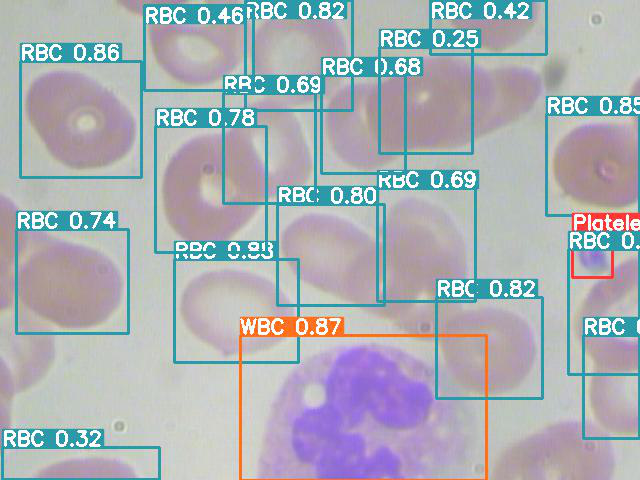

Processing: BloodImage_00301.jpg

image 1/1 /Users/challavishweshwarreddy/complete_blood_count_project/Complete-Blood-Cell-Count-Dataset-master/Training/Images/BloodImage_00301.jpg: 480x640 2 Plateletss, 17 RBCs, 1 WBC, 169.5ms
Speed: 0.6ms preprocess, 169.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


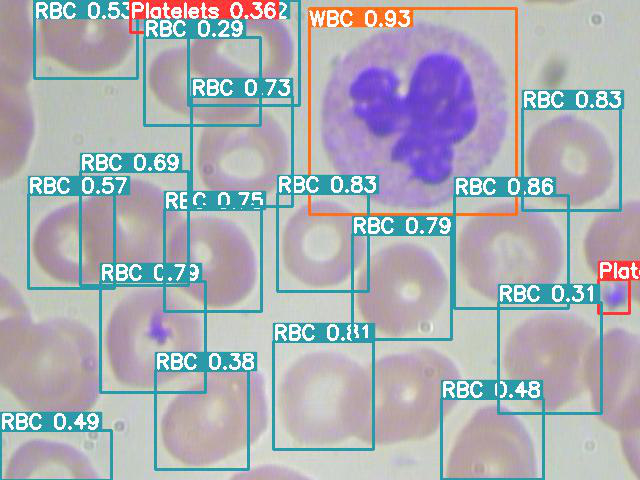

Processing: BloodImage_00117.jpg

image 1/1 /Users/challavishweshwarreddy/complete_blood_count_project/Complete-Blood-Cell-Count-Dataset-master/Training/Images/BloodImage_00117.jpg: 480x640 2 Plateletss, 12 RBCs, 1 WBC, 181.7ms
Speed: 0.8ms preprocess, 181.7ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


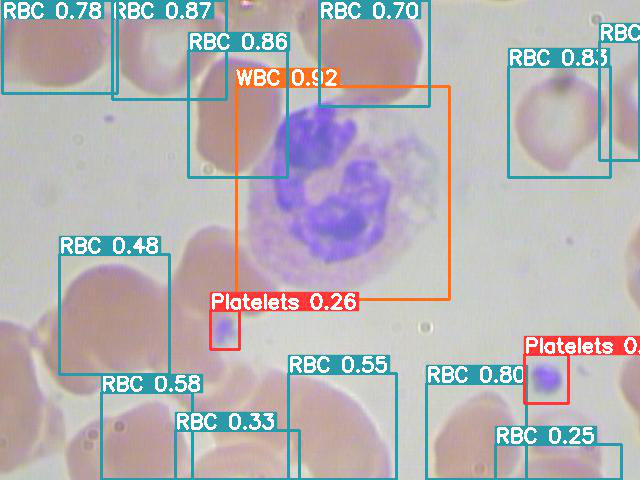

Processing: BloodImage_00103.jpg

image 1/1 /Users/challavishweshwarreddy/complete_blood_count_project/Complete-Blood-Cell-Count-Dataset-master/Training/Images/BloodImage_00103.jpg: 480x640 1 Platelets, 21 RBCs, 2 WBCs, 159.6ms
Speed: 0.8ms preprocess, 159.6ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


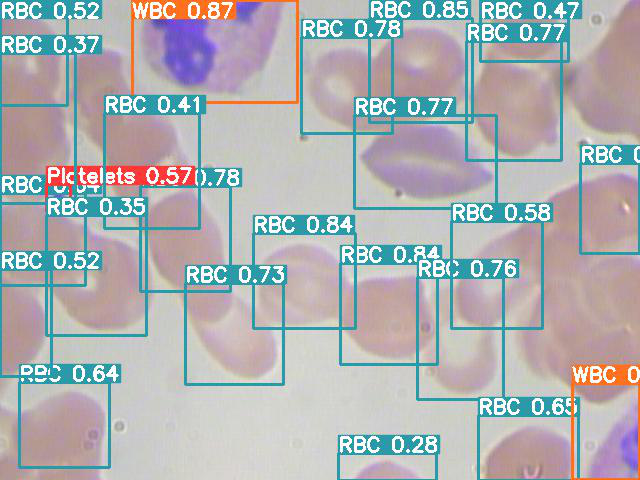

Processing: BloodImage_00063.jpg

image 1/1 /Users/challavishweshwarreddy/complete_blood_count_project/Complete-Blood-Cell-Count-Dataset-master/Training/Images/BloodImage_00063.jpg: 480x640 15 RBCs, 1 WBC, 164.7ms
Speed: 0.6ms preprocess, 164.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


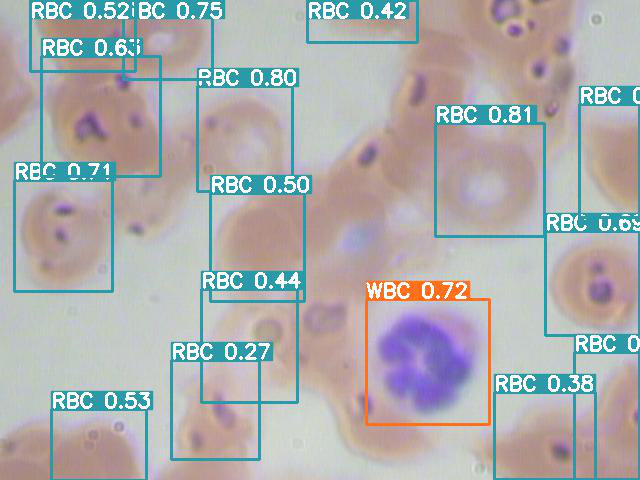

In [21]:
# ✅ 7. Run inference, show and save results
import os
from IPython.display import display
from PIL import Image

# ✅ Create a local folder to store output images
output_dir = "predicted_outputs"  # relative to your notebook directory
os.makedirs(output_dir, exist_ok=True)

# ✅ Process and visualize 5 selected images
for image_path in selected_images:
    print(f"Processing: {os.path.basename(image_path)}")
    results = model.predict(image_path)

    # Visualize result
    render = render_result(model=model, image=image_path, result=results[0])

    # ✅ Save rendered image
    save_path = os.path.join(output_dir, os.path.basename(image_path))
    render.save(save_path)

    # ✅ Show image inline in Jupyter
    display(Image.open(save_path))

In [22]:
import torch
from torch.serialization import add_safe_globals
from torch.nn import Sequential

add_safe_globals([Sequential])

In [23]:
from ultralyticsplus import YOLO

model = YOLO('keremberke/yolov8s-blood-cell-detection')

# Set model parameters
model.overrides['conf'] = 0.25
model.overrides['iou'] = 0.45
model.overrides['agnostic_nms'] = False
model.overrides['max_det'] = 1000

/opt/anaconda3/lib/python3.12/site-packages/ultralytics/nn/tasks.py:634: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location="cpu"), file  # l

In [24]:
selected_images = ""

In [25]:
import os
from IPython.display import display
from PIL import Image

# ✅ Create a local folder to store output images
output_dir = "predicted_outputs_2"  # relative to your notebook directory
os.makedirs(output_dir, exist_ok=True)

# ✅ Process and visualize 5 selected images
for image_path in selected_images:
    print(f"Processing: {os.path.basename(image_path)}")
    results = model.predict(image_path)

    # Visualize result
    render = render_result(model=model, image=image_path, result=results[0])

    # ✅ Save rendered image
    save_path = os.path.join(output_dir, os.path.basename(image_path))
    render.save(save_path)

    # ✅ Show image inline in Jupyter
    display(Image.open(save_path))

In [29]:
image_path = "WhatsApp Image 2025-02-14 at 13.35.14 (1).jpg"

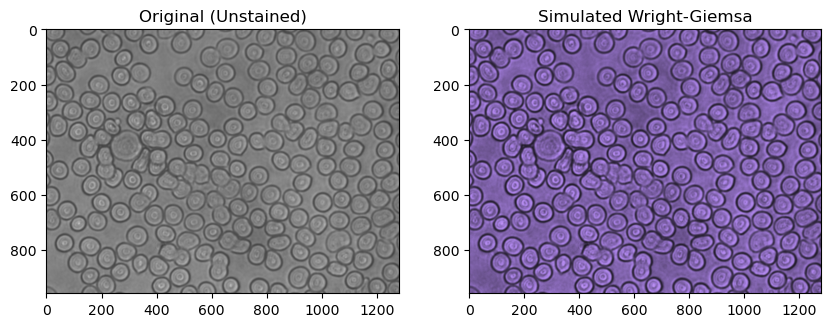

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def simulate_wright_giemsa(image_path, output_path=None, brightness_factor=1.2):
    # Load the unstained image (convert to RGB if needed)
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ensure RGB format
    
    # Convert to grayscale for pseudo-staining
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Normalize and enhance contrast (adjust CLAHE for better details)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    
    # Create a 3-channel image for coloring
    colored = np.zeros_like(img)
    
    # Simulate Wright-Giemsa colors:
    # - Nuclei: Purple/Blue (high-intensity regions)
    # - Cytoplasm/RBCs: Pink/Light Blue (mid/low-intensity regions)
    colored[:, :, 0] = np.clip(gray * 0.7 * brightness_factor, 0, 255)    # Red channel (pink)
    colored[:, :, 1] = np.clip(gray * 0.5 * brightness_factor, 0, 255)   # Green channel (modulated)
    colored[:, :, 2] = np.clip(gray * 1.0 * brightness_factor, 0, 255)   # Blue channel (dominant for purple)
    
    # Post-processing to enhance stain-like appearance
    colored = cv2.addWeighted(colored, 0.8, img, 0.2, 0)  # Blend with original
    
    # Convert to uint8
    colored = np.uint8(colored)
    
    # Save or display
    if output_path:
        cv2.imwrite(output_path, cv2.cvtColor(colored, cv2.COLOR_RGB2BGR))
    
    plt.figure(figsize=(10, 6))
    plt.subplot(121), plt.imshow(img), plt.title("Original (Unstained)")
    plt.subplot(122), plt.imshow(colored), plt.title("Simulated Wright-Giemsa")
    plt.show()
    
    return colored

# Usage
input_image = "WhatsApp Image 2025-02-14 at 13.35.14 (1).jpg"  # Replace with your image path
output_image = "simulated_wright_giemsa.jpg"
simulated_image = simulate_wright_giemsa(input_image, output_image)

python(84488) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



image 1/1 /Users/challavishweshwarreddy/complete_blood_count_project/simulated_wright_giemsa.jpg: 480x640 51 RBCs, 1 WBC, 168.5ms
Speed: 10.9ms preprocess, 168.5ms inference, 13.8ms postprocess per image at shape (1, 3, 480, 640)


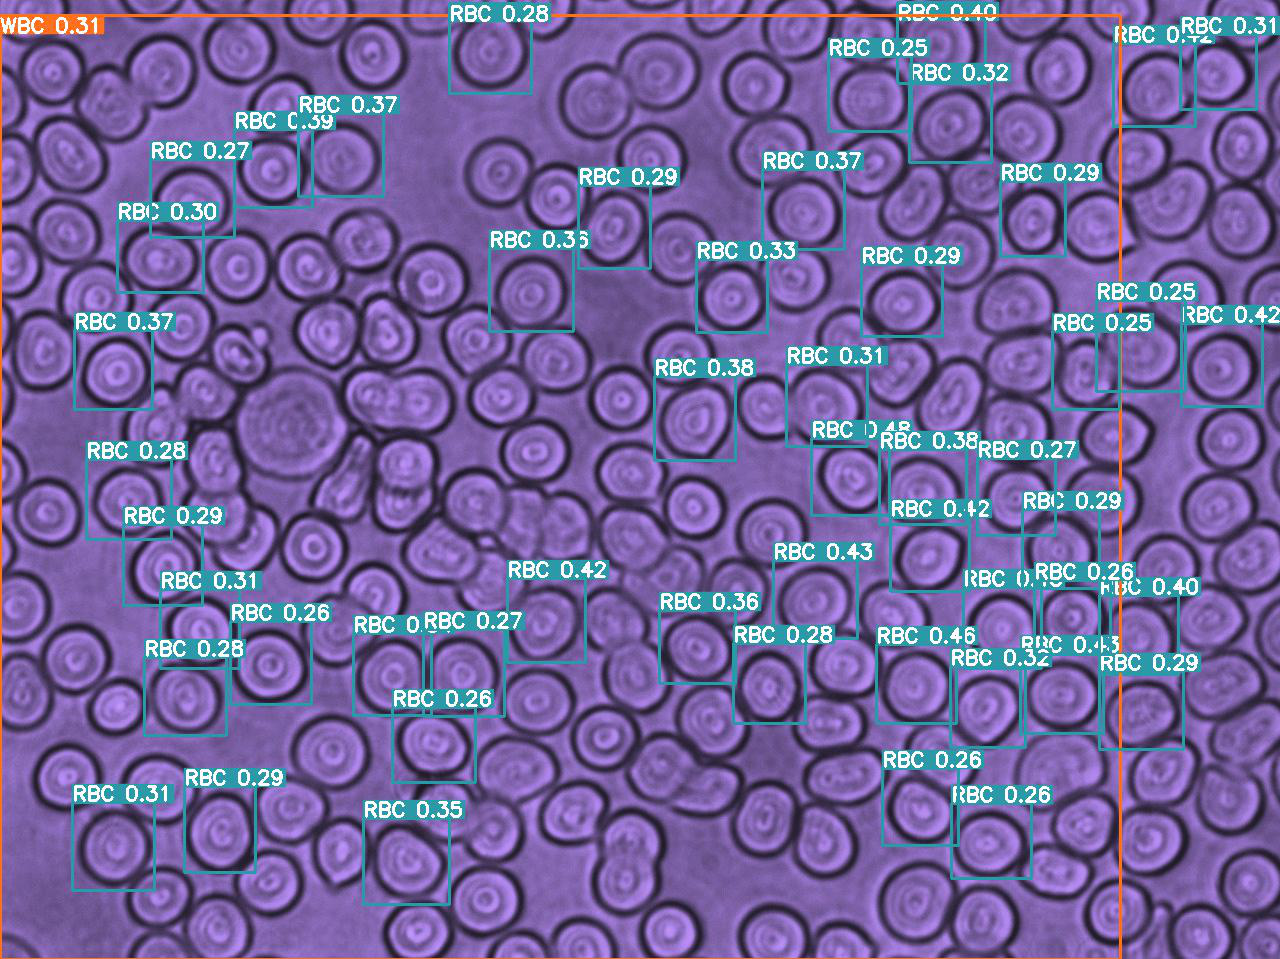

Saved prediction to predicted_output_5.jpg


In [45]:
image_path = "simulated_wright_giemsa.jpg"

# Step 6: Run inference
results = model.predict(image_path)

# Step 7: Visualize and display result
render = render_result(model=model, image=image_path, result=results[0])
#render.show()

# Optional: Save result to file
output_path = os.path.join("predicted_output_5.jpg")
render.save(output_path)
display(Image.open(output_path))
print(f"Saved prediction to {output_path}")